In [1]:
# Import packages
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.linear_model import Lasso
import matplotlib.pyplot as plt

## Preparing the Historical Dataset

In [2]:
crop_yield_df = pd.read_excel('data/crop_yield.xlsx')
historical_weather_df = pd.read_excel('data/historical_weather.xlsx')
soil_df = pd.read_csv('data/average_soil_data.csv')
economy_df = pd.read_csv('data/inflation_interest.csv')
economy_df.columns = ['Year', 'Inflation annual %', 'Real GDP annual growth %', 'Population']

soil_df['STATE'] = soil_df['STATE'].replace('Andaman and Nicobar', 'Andaman and Nicobar Islands')
soil_df['STATE'] = soil_df['STATE'].replace('Chattisgarh', 'Chhattisgarh')
soil_df['STATE'] = soil_df['STATE'].replace('Pondicherry', 'Puducherry')
soil_df['STATE'] = soil_df['STATE'].replace('Uttrakhand', 'Uttarakhand')

merged_df = pd.merge(crop_yield_df, economy_df, on=['Year'], how = 'left')
merged_df = pd.merge(merged_df, historical_weather_df, left_on=['State', 'Year', 'Season'], right_on=['state', 'year', 'season'], how='left')
merged_df.drop(['state', 'year', 'season'], axis=1, inplace=True)
merged_df = pd.merge(merged_df, soil_df, left_on=['State'], right_on=['STATE'], how='left')
merged_df.drop(['STATE'], axis=1, inplace=True)
# merged_df.to_csv('data/yield_weather_soil_econ.csv', index=False)
# df = pd.read_csv('data/yield_weather_soil_econ.csv')

df = merged_df
df.rename(columns={
    'State': 'state',
    'Crop': 'crop',
    'Year': 'year',
    'Season': 'season',
    'Yield (Ton./Ha.)': 'yield',
}, inplace=True)
df

,state,crop,year,season,yield,Inflation annual %,Real GDP annual growth %,Population,temperature_2m_min,temperature_2m_max,precipitation_sum,snowfall_sum,Mean_N_SOIL,Mean_P_SOIL,Mean_K_SOIL,Mean_TEMPERATURE,Mean_HUMIDITY,Mean_PH
0,Andaman and Nicobar Islands,Sesamum,1998.0,Summer,0.00,13.230839,6.184416,1021434576,26.812971,29.232831,6.618692,0.0,81.466667,50.133333,40.333333,23.536551,81.890278,6.628980
1,Andaman and Nicobar Islands,Sesamum,1999.0,Summer,0.00,4.669820,8.845756,1040500054,26.135401,28.180261,7.464953,0.0,81.466667,50.133333,40.333333,23.536551,81.890278,6.628980
2,Andaman and Nicobar Islands,Sesamum,2000.0,Summer,0.00,4.009436,3.840991,1059633675,26.000822,28.181195,9.107009,0.0,81.466667,50.133333,40.333333,23.536551,81.890278,6.628980
3,Andaman and Nicobar Islands,Sesamum,2001.0,Summer,0.00,3.779293,4.823966,1078970907,26.412738,28.615074,7.593458,0.0,81.466667,50.133333,40.333333,23.536551,81.890278,6.628980
4,Andaman and Nicobar Islands,Sesamum,2002.0,Summer,0.00,4.297152,3.803975,1098313039,26.603625,28.882831,6.100935,0.0,81.466667,50.133333,40.333333,23.536551,81.890278,6.628980
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5429,West Bengal,Sesamum,2019.0,Winter,0.72,3.729506,3.871437,1383112050,13.675666,25.720111,1.016667,0.0,97.040323,32.241935,31.806452,25.452349,62.822172,6.776599
5430,West Bengal,Sesamum,2020.0,Winter,0.77,6.623437,-5.831053,1396387127,13.431307,25.125263,0.467033,0.0,97.040323,32.241935,31.806452,25.452349,62.822172,6.776599
5431,West Bengal,Sesamum,2021.0,Winter,0.74,5.131407,9.050278,1407563842,13.999555,26.281777,0.723333,0.0,97.040323,32.241935,31.806452,25.452349,62.822172,6.776599
5432,West Bengal,Sesamum,2022.0,Winter,0.71,6.699034,7.239693,1417173173,13.484555,25.273999,1.406667,0.0,97.040323,32.241935,31.806452,25.452349,62.822172,6.776599


In [3]:
historical_weather_df

,state,year,season,temperature_2m_min,temperature_2m_max,precipitation_sum,snowfall_sum
0,Andaman and Nicobar Islands,1998.0,Autumn,25.755311,27.662688,13.590164,0.0
1,Andaman and Nicobar Islands,1998.0,Summer,26.812971,29.232831,6.618692,0.0
2,Andaman and Nicobar Islands,1998.0,Winter,25.968444,28.243444,0.535556,0.0
3,Andaman and Nicobar Islands,1999.0,Autumn,25.469245,27.538917,8.572131,0.0
4,Andaman and Nicobar Islands,1999.0,Summer,26.135401,28.180261,7.464953,0.0
...,...,...,...,...,...,...,...
1633,West Bengal,2022.0,Summer,24.807457,34.011665,5.454673,0.0
1634,West Bengal,2022.0,Winter,13.484555,25.273999,1.406667,0.0
1635,West Bengal,2023.0,Autumn,21.101295,31.243099,1.927869,0.0
1636,West Bengal,2023.0,Summer,24.750448,34.642039,5.535514,0.0


In [4]:
#yield_weather_soil_df = pd.read_csv('yield_weather_soil.csv')

#economy_df.columns = ['year', 'Inflation annual %', 'Real GDP annual growth %', 'Population']
#merged_df = pd.merge(yield_weather_soil_df, economy_df, on=['year'], how = 'left')
#merged_df.to_csv('data/yield_weather_soil_econ.csv', index=False)
#df = merged_df
# df = pd.read_csv('data/yield_weather_soil_econ.csv')
#df

In [5]:
print(sorted(df['state'].unique()))
print(sorted(df['crop'].unique()))
print(sorted(df['season'].unique()))

['Andaman and Nicobar Islands', 'Assam', 'Bihar', 'Chhattisgarh', 'Dadra and Nagar Haveli', 'Gujarat', 'Jharkhand', 'Karnataka', 'Kerala', 'Madhya Pradesh', 'Maharashtra', 'Manipur', 'Meghalaya', 'Mizoram', 'Odisha', 'Puducherry', 'Tamil Nadu', 'Tripura', 'Uttar Pradesh', 'Uttarakhand', 'West Bengal']
['Arhar/Tur', 'Arhur/Tur', 'Bajra', 'Banana', 'Brinjal', 'Coriander', 'Cotton', 'Cowpea', 'Dry Chillies', 'Dry chillies', 'Ginger', 'Gram', 'Groundnut', 'Horse-gram', 'Jowar', 'Jute', 'Maize', 'Moong', 'Niger seed', 'Onion', 'Other Rabi Pulses', 'Other Summer Pulses', 'Peas & Beans', 'Peas & beans', 'Potato', 'Pulses Total', 'Ragi', 'Rapeseed &Mustard', 'Rice', 'Sannhamp', 'Sesamum', 'Small Millets', 'Small millets', 'Soyabean', 'Sugarcane', 'Sunflower', 'Sweet potato', 'Tapioca', 'Tobacco', 'Total Foodgrain', 'Turmeric', 'Urad', 'Wheat']
['Autumn', 'Summer', 'Winter']


In [6]:
df['crop'] = df['crop'].replace('Arhur/Tur', 'Arhar/Tur')
df['crop'] = df['crop'].replace('Dry chillies', 'Dry Chillies')
df['crop'] = df['crop'].replace('Peas & beans', 'Peas & Beans')
df['crop'] = df['crop'].replace('Small millets', 'Small Millets')
df['crop'] = df['crop'].replace('Rapeseed &Mustard', 'Rapeseed & Mustard')

In [7]:
print(len(df['state'].unique()))
print(len(df['crop'].unique()))

21
39


## Understanding the Data

### Finding shape of data and confirming no missing values in each column

In [8]:
print(df.shape)
# Count the number of NaN values in each column
nan_counts = df.isna().sum()

# Print the result
print("Number of NaN values in each column:")
for column, count in nan_counts.items():
    print(f"{column}: {count}")


(5434, 18)
Number of NaN values in each column:
state: 0
crop: 0
year: 0
season: 0
yield: 0
Inflation annual %: 0
Real GDP annual growth %: 0
Population: 0
temperature_2m_min: 0
temperature_2m_max: 0
precipitation_sum: 0
snowfall_sum: 0
Mean_N_SOIL: 0
Mean_P_SOIL: 0
Mean_K_SOIL: 0
Mean_TEMPERATURE: 0
Mean_HUMIDITY: 0
Mean_PH: 0


### Accounting for Missing Data

In [9]:
df = df.dropna()
print(df.shape)
# Count the number of NaN values in each column
nan_counts = df.isna().sum()

# Print the result
print("Number of NaN values in each column:")
for column, count in nan_counts.items():
    print(f"{column}: {count}")


(5434, 18)
Number of NaN values in each column:
state: 0
crop: 0
year: 0
season: 0
yield: 0
Inflation annual %: 0
Real GDP annual growth %: 0
Population: 0
temperature_2m_min: 0
temperature_2m_max: 0
precipitation_sum: 0
snowfall_sum: 0
Mean_N_SOIL: 0
Mean_P_SOIL: 0
Mean_K_SOIL: 0
Mean_TEMPERATURE: 0
Mean_HUMIDITY: 0
Mean_PH: 0


In [10]:
# Remove duplicate rows based on the combination of 'crop', 'state', 'year', and 'season'
duplicate_rows = df[df.duplicated(subset=['crop', 'state', 'year', 'season'], keep=False)]
df.drop_duplicates(subset=['crop', 'state', 'year', 'season'], keep='first', inplace=True)

In [11]:
df.shape

(5382, 18)

In [12]:
all_crops = df['crop'].unique()
all_states = df['state'].unique()
all_seasons = df['season'].unique()
all_years = range(1998, 2024)

all_combinations = pd.DataFrame([(crop, state, year, season) for crop in all_crops for state in all_states for year in all_years for season in all_seasons],
                                columns=['crop', 'state', 'year', 'season'])

merged_df = pd.merge(all_combinations, df, on=['crop', 'state', 'year', 'season'], how='left')

# Replace missing yield values with 0
merged_df['yield'].fillna(0, inplace=True)

# Replace missing values in other columns with the mean value for that column
columns_to_fill = merged_df.columns.difference(['crop', 'state', 'year', 'season', 'yield'])
for column in columns_to_fill:
    mean_value = merged_df[column].mean()
    merged_df[column].fillna(mean_value, inplace=True)
    
df = merged_df
print(df.shape)

(63882, 18)


In [13]:
# Group by 'state' and 'crop', then filter out rows where all values in 'yield' column are zero
filtered_df = df.groupby(['state', 'crop']).filter(lambda x: (x['yield'] != 0).any())
df = filtered_df.reset_index(drop=True)
print(df.shape)

(11700, 18)


In [14]:
df['state'].unique()

array(['Andaman and Nicobar Islands', 'Gujarat', 'Kerala', 'Manipur',
       'Meghalaya', 'Odisha', 'Puducherry', 'West Bengal',
       'Dadra and Nagar Haveli', 'Assam', 'Bihar', 'Jharkhand',
       'Karnataka', 'Madhya Pradesh', 'Tamil Nadu', 'Tripura',
       'Uttar Pradesh', 'Uttarakhand', 'Mizoram', 'Chhattisgarh',
       'Maharashtra'], dtype=object)

In [15]:
df['crop'].unique()

array(['Sesamum', 'Rice', 'Maize', 'Moong', 'Onion', 'Sunflower', 'Bajra',
       'Groundnut', 'Urad', 'Cotton', 'Cowpea', 'Dry Chillies',
       'Horse-gram', 'Jowar', 'Peas & Beans', 'Potato', 'Ragi', 'Banana',
       'Ginger', 'Jute', 'Sugarcane', 'Turmeric', 'Arhar/Tur', 'Wheat',
       'Brinjal', 'Other Rabi Pulses', 'Other Summer Pulses',
       'Small Millets', 'Tobacco', 'Pulses Total', 'Total Foodgrain',
       'Soyabean', 'Sweet potato', 'Tapioca', 'Sannhamp', 'Coriander',
       'Gram', 'Niger seed', 'Rapeseed & Mustard'], dtype=object)

In [16]:
print(len(df['state'].unique()))
print(len(df['crop'].unique()))

21
39


In [17]:
historical_df = df
historical_df

,crop,state,year,season,yield,Inflation annual %,Real GDP annual growth %,Population,temperature_2m_min,temperature_2m_max,precipitation_sum,snowfall_sum,Mean_N_SOIL,Mean_P_SOIL,Mean_K_SOIL,Mean_TEMPERATURE,Mean_HUMIDITY,Mean_PH
0,Sesamum,Andaman and Nicobar Islands,1998,Summer,0.0,13.230839,6.184416,1.021435e+09,26.812971,29.232831,6.618692,0.00000,81.466667,50.133333,40.333333,23.536551,81.890278,6.628980
1,Sesamum,Andaman and Nicobar Islands,1998,Autumn,0.0,6.347550,6.193452,1.241857e+09,19.147960,28.225199,3.347841,0.00012,57.655611,43.953296,36.220298,24.270298,73.896961,6.445453
2,Sesamum,Andaman and Nicobar Islands,1998,Winter,0.0,6.347550,6.193452,1.241857e+09,19.147960,28.225199,3.347841,0.00012,57.655611,43.953296,36.220298,24.270298,73.896961,6.445453
3,Sesamum,Andaman and Nicobar Islands,1999,Summer,0.0,4.669820,8.845756,1.040500e+09,26.135401,28.180261,7.464953,0.00000,81.466667,50.133333,40.333333,23.536551,81.890278,6.628980
4,Sesamum,Andaman and Nicobar Islands,1999,Autumn,0.0,6.347550,6.193452,1.241857e+09,19.147960,28.225199,3.347841,0.00012,57.655611,43.953296,36.220298,24.270298,73.896961,6.445453
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11695,Rapeseed & Mustard,Dadra and Nagar Haveli,2022,Autumn,0.0,6.347550,6.193452,1.241857e+09,19.147960,28.225199,3.347841,0.00012,57.655611,43.953296,36.220298,24.270298,73.896961,6.445453
11696,Rapeseed & Mustard,Dadra and Nagar Haveli,2022,Winter,0.0,6.699034,7.239693,1.417173e+09,17.884889,31.020444,0.075556,0.00000,77.646018,48.424779,22.398230,22.499366,66.559053,6.277621
11697,Rapeseed & Mustard,Dadra and Nagar Haveli,2023,Summer,0.0,6.347550,6.193452,1.241857e+09,19.147960,28.225199,3.347841,0.00012,57.655611,43.953296,36.220298,24.270298,73.896961,6.445453
11698,Rapeseed & Mustard,Dadra and Nagar Haveli,2023,Autumn,0.0,6.347550,6.193452,1.241857e+09,19.147960,28.225199,3.347841,0.00012,57.655611,43.953296,36.220298,24.270298,73.896961,6.445453


In [18]:
df.to_csv('historical_ywse_cleaned.csv', index=False)

### Listing the crops based on quantity produced over the years

In [19]:
total_crop_yield = []
unique_crops = df['crop'].unique()
for crop in unique_crops:
    crop_yield_sum = df[(df['crop'] == crop)]['yield'].sum()
    total_crop_yield.append((crop, crop_yield_sum))
    
sorted_total_crop_yield = sorted(total_crop_yield, key = lambda x: x[1] ,reverse=True)
for (c, y) in sorted_total_crop_yield:
    print(f"Total yield of {c}: {y}")

Total yield of Sugarcane: 2764.75
Total yield of Maize: 1531.27
Total yield of Rice: 1446.09
Total yield of Potato: 839.36
Total yield of Onion: 802.11
Total yield of Banana: 657.8
Total yield of Groundnut: 229.42000000000002
Total yield of Ragi: 149.01999999999998
Total yield of Sesamum: 135.51999999999998
Total yield of Jute: 131.36
Total yield of Dry Chillies: 131.15
Total yield of Bajra: 109.26
Total yield of Moong: 87.24
Total yield of Brinjal: 69.27000000000001
Total yield of Urad: 69.11
Total yield of Wheat: 68.44
Total yield of Jowar: 64.38
Total yield of Sunflower: 53.89
Total yield of Tobacco: 39.5
Total yield of Peas & Beans: 32.809999999999995
Total yield of Cotton: 20.5
Total yield of Rapeseed & Mustard: 19.25
Total yield of Small Millets: 16.29
Total yield of Gram: 13.23
Total yield of Horse-gram: 12.78
Total yield of Other Summer Pulses: 8.469999999999999
Total yield of Arhar/Tur: 8.05
Total yield of Sannhamp: 7.55
Total yield of Niger seed: 7.040000000000001
Total yield

### Selecting crops that have at least 100 Ton./Ha. produced over the years

In [20]:
# Select crops whose yield is more than or equal to 100
selected_crops = [c for (c, y) in sorted_total_crop_yield if y >= 100]

# Filter rows from df for selected crops
df = df[df['crop'].isin(selected_crops)]

# Print unique crops in the DataFrame
unique_crops = df['crop'].unique()
print("Unique crops in the DataFrame that have at least 100 Ton./Ha.:")
for crop in unique_crops:
    print(crop)

Unique crops in the DataFrame that have at least 100 Ton./Ha.:
Sesamum
Rice
Maize
Onion
Bajra
Groundnut
Dry Chillies
Potato
Ragi
Banana
Jute
Sugarcane


### Viewing data on a graph

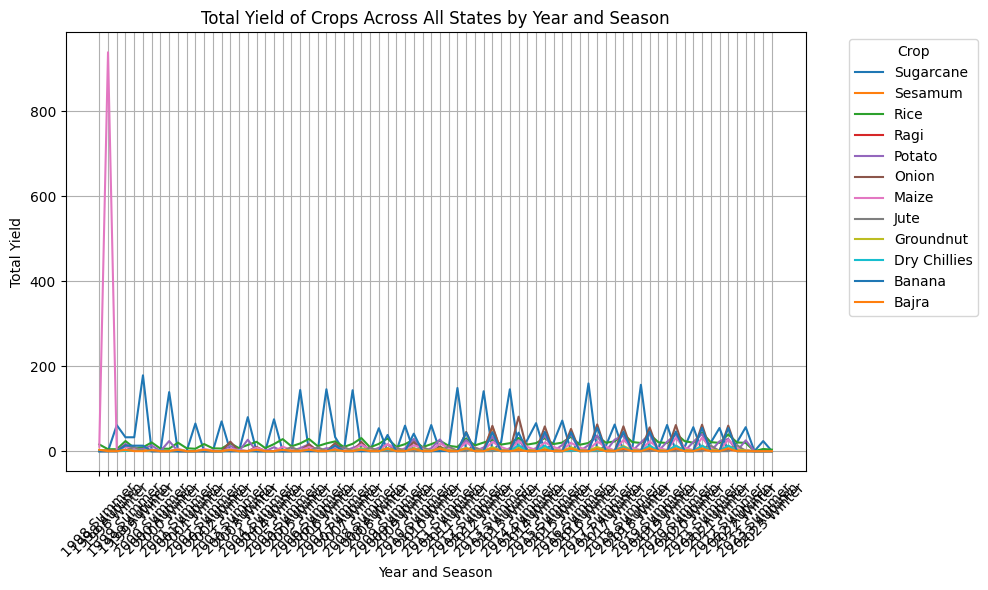

In [21]:
# Group the DataFrame by 'Year', 'season', and 'crop', and sum up the yield
grouped_df = df.groupby(['year', 'season', 'crop'])['yield'].sum().reset_index()

# Create a new column combining 'Year' and 'season' information
def map_season(season):
    return '1' if season == 'Summer' else ('2' if season == 'Autumn' else '3')

grouped_df['Year_Season'] = grouped_df.apply(lambda row: str(row['year']) + '_' + map_season(row['season']) + '_' + row['season'], axis=1)

# Sort the DataFrame by 'Year_Season'
grouped_df = grouped_df.sort_values('Year_Season')

# Plot the time series graph for each crop
plt.figure(figsize=(10, 6))
for crop in grouped_df['crop'].unique():
    crop_data = grouped_df[grouped_df['crop'] == crop]
    plt.plot(crop_data['Year_Season'], crop_data['yield'], label=crop)

plt.xlabel('Year and Season')
plt.ylabel('Total Yield')
plt.title('Total Yield of Crops Across All States by Year and Season')
original_ticks = plt.xticks()[0]
seasons = ['Summer', 'Autumn', 'Winter']
years = range(1998, 2024)
custom_labels = [f"{year} {season}" for year in years for season in seasons]
plt.xticks(original_ticks, custom_labels, rotation=45)

plt.legend(title='Crop', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()


C:\Users\renee\AppData\Local\Temp\ipykernel_17360\3219316145.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  grouped_df_large['Year_Season'] = grouped_df_large.apply(lambda row: str(row['year']) + ' ' + map_season(row['season']) +' ' + row['season'], axis=1)


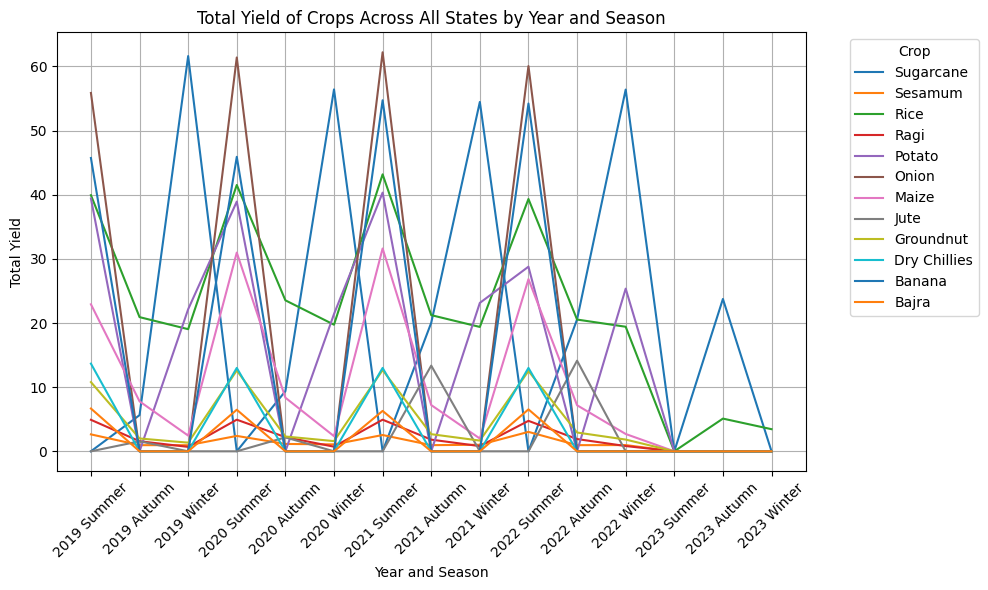

In [22]:
# Zoomed in graph
grouped_df_reduced = df.groupby(['year', 'season', 'crop'])['yield'].sum().reset_index()
grouped_df_reduced['Year_Season'] = grouped_df_reduced['year'].astype(str) + ' ' + grouped_df_reduced['season']
grouped_df_large = grouped_df_reduced[grouped_df_reduced['year'] >= 2019]

def map_season(season):
    return '1' if season == 'Summer' else ('2' if season == 'Autumn' else '3')

grouped_df_large['Year_Season'] = grouped_df_large.apply(lambda row: str(row['year']) + ' ' + map_season(row['season']) +' ' + row['season'], axis=1)
grouped_df_large = grouped_df_large.sort_values('Year_Season')

plt.figure(figsize=(10, 6))
for crop in grouped_df_large['crop'].unique():
    crop_data = grouped_df_large[grouped_df_large['crop'] == crop]
    plt.plot(crop_data['Year_Season'], crop_data['yield'], label=crop)

plt.xlabel('Year and Season')
plt.ylabel('Total Yield')
plt.title('Total Yield of Crops Across All States by Year and Season')
original_ticks = plt.xticks()[0]
seasons = ['Summer', 'Autumn', 'Winter']
years = range(2019, 2024)
custom_labels = [f"{year} {season}" for year in years for season in seasons]
plt.xticks(original_ticks, custom_labels, rotation=45)
plt.legend(title='Crop', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.grid(True)
plt.tight_layout()  # Adjust layout to prevent cropping of labels
plt.show()


## Preparing the Forcasted Dataset

In [23]:
future_df = pd.read_excel('data/forecast_weather.xlsx')
future_df.columns = future_df.columns.str.replace(r' \(\D+\)', '', regex=True)
future_df['yield'] = 0
future_df['year'] = future_df['year'].astype(int)
future_df = future_df[future_df['year'] <= 2028]
merged_future_df = pd.merge(future_df, soil_df, left_on=['state'], right_on=['STATE'],  how='left')
merged_future_df.drop(['STATE'], axis=1, inplace=True)
merged_future_df = pd.merge(merged_future_df, economy_df, left_on=['year'], right_on=['Year'], how = 'left')
merged_future_df.drop(['Year'], axis=1, inplace=True)
future_df = merged_future_df
future_df

,state,year,season,temperature_2m_min,temperature_2m_max,precipitation_sum,snowfall_sum,yield,Mean_N_SOIL,Mean_P_SOIL,Mean_K_SOIL,Mean_TEMPERATURE,Mean_HUMIDITY,Mean_PH,Inflation annual %,Real GDP annual growth %,Population
0,Andaman and Nicobar Islands,2024,Autumn,26.057377,28.072131,10.957213,0.0,0,81.466667,50.133333,40.333333,23.536551,81.890278,6.628980,4.55,6.29,1441720000
1,Andaman and Nicobar Islands,2024,Summer,27.157944,29.362617,9.229533,0.0,0,81.466667,50.133333,40.333333,23.536551,81.890278,6.628980,4.55,6.29,1441720000
2,Andaman and Nicobar Islands,2024,Winter,26.171429,28.542857,4.810659,0.0,0,81.466667,50.133333,40.333333,23.536551,81.890278,6.628980,4.55,6.29,1441720000
3,Andaman and Nicobar Islands,2025,Autumn,26.039344,28.016393,11.596885,0.0,0,81.466667,50.133333,40.333333,23.536551,81.890278,6.628980,4.09,6.33,1454610000
4,Andaman and Nicobar Islands,2025,Summer,26.887383,29.115888,7.736028,0.0,0,81.466667,50.133333,40.333333,23.536551,81.890278,6.628980,4.09,6.33,1454610000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
310,Mizoram,2027,Summer,20.825701,29.735981,6.913411,0.0,0,100.500000,16.944444,50.166667,28.661707,92.656773,6.370987,4.00,6.35,1479580000
311,Mizoram,2027,Winter,10.713333,24.126667,0.256111,0.0,0,100.500000,16.944444,50.166667,28.661707,92.656773,6.370987,4.00,6.35,1479580000
312,Mizoram,2028,Autumn,17.068852,26.073770,3.528033,0.0,0,100.500000,16.944444,50.166667,28.661707,92.656773,6.370987,4.00,6.26,1491670000
313,Mizoram,2028,Summer,20.650935,29.543925,6.294673,0.0,0,100.500000,16.944444,50.166667,28.661707,92.656773,6.370987,4.00,6.26,1491670000


In [24]:
# Find all the unique combinations of state and crops in the historical dataset

state_crops = historical_df[['state', 'crop']]
state_crops = state_crops.drop_duplicates().reset_index(drop=True)
len(state_crops['state'].unique())

21

In [25]:
state_year_season = future_df[['state', 'year', 'season']].drop_duplicates()
len(state_year_season['state'].unique())

21

In [26]:
# Perform a cross join between state_crops and state_year_season to get all possible combinations of state, year, season and crop, based on the available crop for the corresponding states in the historical dataset

state_crops['key'] = 0
state_year_season['key'] = 0
state_year_season_crop = pd.merge(state_crops, state_year_season, on=['key', 'state']).drop('key', axis=1)
state_year_season_crop

,state,crop,year,season
0,Andaman and Nicobar Islands,Sesamum,2024,Autumn
1,Andaman and Nicobar Islands,Sesamum,2024,Summer
2,Andaman and Nicobar Islands,Sesamum,2024,Winter
3,Andaman and Nicobar Islands,Sesamum,2025,Autumn
4,Andaman and Nicobar Islands,Sesamum,2025,Summer
...,...,...,...,...
2245,Maharashtra,Maize,2027,Summer
2246,Maharashtra,Maize,2027,Winter
2247,Maharashtra,Maize,2028,Autumn
2248,Maharashtra,Maize,2028,Summer


In [27]:
future_df = pd.merge(state_year_season_crop, future_df, on=['state', 'year', 'season'], how='left')
len(future_df['crop'].unique())
future_df

,state,crop,year,season,temperature_2m_min,temperature_2m_max,precipitation_sum,snowfall_sum,yield,Mean_N_SOIL,Mean_P_SOIL,Mean_K_SOIL,Mean_TEMPERATURE,Mean_HUMIDITY,Mean_PH,Inflation annual %,Real GDP annual growth %,Population
0,Andaman and Nicobar Islands,Sesamum,2024,Autumn,26.057377,28.072131,10.957213,0.0,0,81.466667,50.133333,40.333333,23.536551,81.890278,6.628980,4.55,6.29,1441720000
1,Andaman and Nicobar Islands,Sesamum,2024,Summer,27.157944,29.362617,9.229533,0.0,0,81.466667,50.133333,40.333333,23.536551,81.890278,6.628980,4.55,6.29,1441720000
2,Andaman and Nicobar Islands,Sesamum,2024,Winter,26.171429,28.542857,4.810659,0.0,0,81.466667,50.133333,40.333333,23.536551,81.890278,6.628980,4.55,6.29,1441720000
3,Andaman and Nicobar Islands,Sesamum,2025,Autumn,26.039344,28.016393,11.596885,0.0,0,81.466667,50.133333,40.333333,23.536551,81.890278,6.628980,4.09,6.33,1454610000
4,Andaman and Nicobar Islands,Sesamum,2025,Summer,26.887383,29.115888,7.736028,0.0,0,81.466667,50.133333,40.333333,23.536551,81.890278,6.628980,4.09,6.33,1454610000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2245,Maharashtra,Maize,2027,Summer,24.165421,33.208879,3.721308,0.0,0,28.228395,68.259259,19.228395,27.105562,64.822194,7.013929,4.00,6.35,1479580000
2246,Maharashtra,Maize,2027,Winter,15.670000,28.705556,0.049444,0.0,0,28.228395,68.259259,19.228395,27.105562,64.822194,7.013929,4.00,6.35,1479580000
2247,Maharashtra,Maize,2028,Autumn,19.860656,29.180328,0.927213,0.0,0,28.228395,68.259259,19.228395,27.105562,64.822194,7.013929,4.00,6.26,1491670000
2248,Maharashtra,Maize,2028,Summer,24.168692,33.493458,2.517804,0.0,0,28.228395,68.259259,19.228395,27.105562,64.822194,7.013929,4.00,6.26,1491670000


In [28]:
print(sorted(future_df['state'].unique()))
print(sorted(future_df['crop'].unique()))
print(sorted(future_df['season'].unique()))

['Andaman and Nicobar Islands', 'Assam', 'Bihar', 'Chhattisgarh', 'Dadra and Nagar Haveli', 'Gujarat', 'Jharkhand', 'Karnataka', 'Kerala', 'Madhya Pradesh', 'Maharashtra', 'Manipur', 'Meghalaya', 'Mizoram', 'Odisha', 'Puducherry', 'Tamil Nadu', 'Tripura', 'Uttar Pradesh', 'Uttarakhand', 'West Bengal']
['Arhar/Tur', 'Bajra', 'Banana', 'Brinjal', 'Coriander', 'Cotton', 'Cowpea', 'Dry Chillies', 'Ginger', 'Gram', 'Groundnut', 'Horse-gram', 'Jowar', 'Jute', 'Maize', 'Moong', 'Niger seed', 'Onion', 'Other Rabi Pulses', 'Other Summer Pulses', 'Peas & Beans', 'Potato', 'Pulses Total', 'Ragi', 'Rapeseed & Mustard', 'Rice', 'Sannhamp', 'Sesamum', 'Small Millets', 'Soyabean', 'Sugarcane', 'Sunflower', 'Sweet potato', 'Tapioca', 'Tobacco', 'Total Foodgrain', 'Turmeric', 'Urad', 'Wheat']
['Autumn', 'Summer', 'Winter']


In [29]:
print(len(future_df['state'].unique()))
print(len(future_df['crop'].unique()))

21
39


In [30]:
future_df

,state,crop,year,season,temperature_2m_min,temperature_2m_max,precipitation_sum,snowfall_sum,yield,Mean_N_SOIL,Mean_P_SOIL,Mean_K_SOIL,Mean_TEMPERATURE,Mean_HUMIDITY,Mean_PH,Inflation annual %,Real GDP annual growth %,Population
0,Andaman and Nicobar Islands,Sesamum,2024,Autumn,26.057377,28.072131,10.957213,0.0,0,81.466667,50.133333,40.333333,23.536551,81.890278,6.628980,4.55,6.29,1441720000
1,Andaman and Nicobar Islands,Sesamum,2024,Summer,27.157944,29.362617,9.229533,0.0,0,81.466667,50.133333,40.333333,23.536551,81.890278,6.628980,4.55,6.29,1441720000
2,Andaman and Nicobar Islands,Sesamum,2024,Winter,26.171429,28.542857,4.810659,0.0,0,81.466667,50.133333,40.333333,23.536551,81.890278,6.628980,4.55,6.29,1441720000
3,Andaman and Nicobar Islands,Sesamum,2025,Autumn,26.039344,28.016393,11.596885,0.0,0,81.466667,50.133333,40.333333,23.536551,81.890278,6.628980,4.09,6.33,1454610000
4,Andaman and Nicobar Islands,Sesamum,2025,Summer,26.887383,29.115888,7.736028,0.0,0,81.466667,50.133333,40.333333,23.536551,81.890278,6.628980,4.09,6.33,1454610000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2245,Maharashtra,Maize,2027,Summer,24.165421,33.208879,3.721308,0.0,0,28.228395,68.259259,19.228395,27.105562,64.822194,7.013929,4.00,6.35,1479580000
2246,Maharashtra,Maize,2027,Winter,15.670000,28.705556,0.049444,0.0,0,28.228395,68.259259,19.228395,27.105562,64.822194,7.013929,4.00,6.35,1479580000
2247,Maharashtra,Maize,2028,Autumn,19.860656,29.180328,0.927213,0.0,0,28.228395,68.259259,19.228395,27.105562,64.822194,7.013929,4.00,6.26,1491670000
2248,Maharashtra,Maize,2028,Summer,24.168692,33.493458,2.517804,0.0,0,28.228395,68.259259,19.228395,27.105562,64.822194,7.013929,4.00,6.26,1491670000


In [31]:
future_df.to_csv('future_ywse_cleaned.csv', index=False)

## Feature Selection

In [32]:
# Drop non-numeric columns
df_numeric = df.drop(['year', 'state', 'crop', 'season'], axis=1)

# Define features and target variable
X = df_numeric.drop('yield', axis=1)
y = df_numeric['yield']

# Train model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
lasso = Lasso(alpha=0.1)
lasso.fit(X_train, y_train)
selected_features = X.columns[lasso.coef_ != 0]
print("Selected Features:", selected_features)
selected_features = pd.DataFrame(selected_features, columns=['Features'])

Selected Features: Index(['Inflation annual %', 'Population', 'temperature_2m_min',
       'temperature_2m_max', 'precipitation_sum', 'Mean_N_SOIL', 'Mean_P_SOIL',
       'Mean_K_SOIL', 'Mean_HUMIDITY'],
      dtype='object')


In [33]:
selected_features.to_csv('selected_features.csv', index=False)